# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.280381,True,4.984775
1,0.409547,False,1.256227
2,-0.067936,False,-0.429682
3,-0.305212,True,3.763655
4,0.676184,True,4.889975
...,...,...,...
995,-0.201678,False,0.124943
996,1.331673,True,4.464599
997,-0.084787,False,1.308536
998,2.121081,True,9.168982


<Axes: xlabel='v0'>

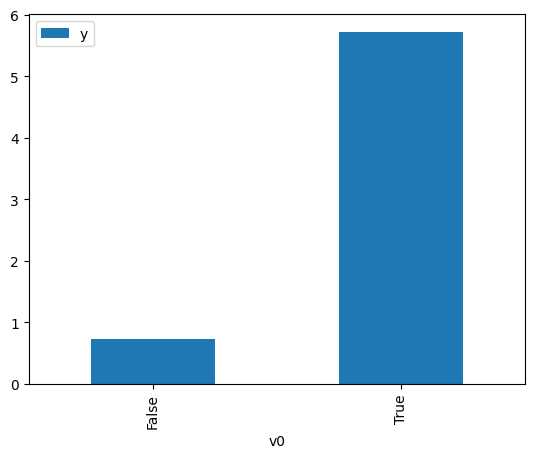

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

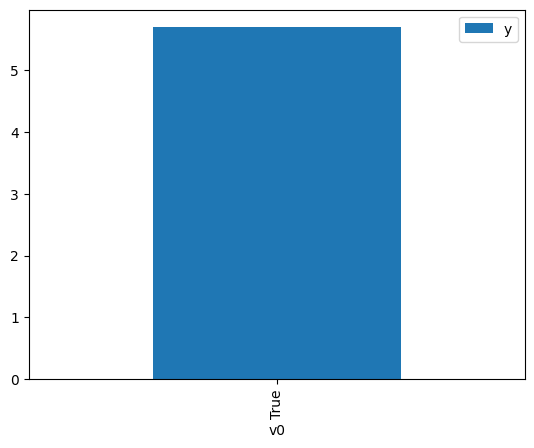

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.216353,False,0.747290,0.581794,1.718822
1,1.462521,False,0.142191,0.352434,2.837409
2,-0.202149,False,-0.448636,0.579861,1.724552
3,-0.511115,False,-0.961576,0.621264,1.609622
4,1.234835,False,2.054650,0.381997,2.617819
...,...,...,...,...,...
995,1.236211,False,1.417983,0.381816,2.619063
996,-0.019313,False,-0.296941,0.554778,1.802522
997,1.717577,False,0.107976,0.320618,3.118978
998,-0.625083,False,-1.497697,0.636134,1.571995


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.308973,True,5.026077,0.490880,2.037156
1,-0.186285,True,5.279055,0.422301,2.367979
2,0.167132,True,7.328632,0.471089,2.122741
3,2.319284,True,9.557565,0.747871,1.337129
4,1.253713,True,5.755199,0.620491,1.611628
...,...,...,...,...,...
995,2.987464,True,10.520455,0.811656,1.232049
996,2.302290,True,6.568960,0.746076,1.340346
997,-0.038793,True,2.908502,0.442534,2.259715
998,0.838221,True,4.981601,0.564481,1.771538


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.005e+04
Date:                Wed, 19 Mar 2025   Prob (F-statistic):                        0.00
Time:                        15:12:10   Log-Likelihood:                         -1421.8
No. Observations:                1000   AIC:                                      2848.
Df Residuals:                     998   BIC:                                      2857.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0820      0.031     34.373      0.000       1.020       1.144
x2             4.9407      0.052     94.820      0.000       4.838       5.043
==============================================================================
Omnibus:                        0.684   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.765
Skew:                          -0.028   Prob(JB):                        0.682
Kurtosis:                       2.877   Cond. No.                         2.29
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""